# Análisis socio-econónicos y de criminalidad en Costa Rica

### Introducción

Haciendo uso de herramientas tecnológicas como la televisión e internet, nos enteramos de lo sucedido en nuestro país, vemos como día a día la situación económica de nuestro país cambia, y por ende, la situación de nuestra sociedad también. 
En este punto, es importante decir que, para que un país avance su nivel económico y social debe ser bueno, y mostrar las cualidades para que sea un país con una buena reputación.
Sin embargo, hoy, nos enfrentamos a muchos problemas económicos, y cada día, las personas se ven cada vez más envueltas en situaciones complicadas con el dinero y esto se ve agrabado con el hecho de que la delicuencia sigue aumentanto. Muchas personas viven con el miedo contante de ser victimas de algún delito.
Este aumento en la delincuencia, puede verse influenciado por los mismos problemas económicos que enfrentan las diferentes familias a lo largo de nuestro país, porque apesar que se un acto delictivo puede ocurrir en cualquier parte del país, estas situaciones se ven mayormente es los sectores más vulnerables de la población.
Investigaciones en análisis de datos asociados a delitos, han concluido que algunos factores, como son la educación, la pobreza y el desempleo pueden influir en el aumento o disminución de la tasa de delitos de una región (Suhong, Param, Parminder y Pooya, 2018) y es por eso que se requiere integrar ambas fuentes de datos. 

In [1]:
import findspark       # Importa la funcionalidad para poder encontrar las caracteristicas necesarias de pyspark 
findspark.init()       # Inicializa el findspark

In [2]:
from pyspark.sql import SparkSession     # Importa la funcionalidad necesaria para poder hacer uso de pyspark por sparkSession 
from pyspark.sql import functions as F
from pyspark.sql.functions import lower, col, isnan, when, trim
from pyspark.sql.types import *
from pyspark.sql import SQLContext
import re
import unicodedata
import psycopg2

import seaborn as sns
import matplotlib.pyplot as plt


from sqlalchemy import create_engine

import pandas as pd    # Importa pandas el cuál ayuda a un mejor procesamiento de los datos

In [3]:
spark=SparkSession.builder.getOrCreate()      # Se abre la sesión de spark

In [4]:
spark      # Revisa si la sesión se abrió correctamente

### Cargando datos de OIJ

In [5]:
# Asigna a la variable OIJ el resultado de la lectura del archivo con la información del OIJ
#OIJ =  pd.read_excel('C:/Users/anner/Desktop/Datos/U/U-1-2021/Bases2/Proyectos/Proyecto3/estadisticas/Estadisticas.xlsx')
OIJ = spark.createDataFrame(pd.read_excel('C:/Users/anner/Desktop/Datos/U/U-1-2021/Bases2/Proyectos/Proyecto3/estadisticas/Estadisticas.xlsx'))

In [6]:
type(OIJ)
#print(OIJ)
OIJ.show()

+------+-----------+-------------------+-------------------+-----------+--------------------+-------------+------+------------+----------+----------+-------------+
|Delito|  SubDelito|              Fecha|               Hora|    Victima|          SubVictima|         Edad|Genero|Nacionalidad| Provincia|    Canton|     Distrito|
+------+-----------+-------------------+-------------------+-----------+--------------------+-------------+------+------------+----------+----------+-------------+
|ASALTO|ARMA BLANCA|2021-01-07 00:00:00|12:00:00 - 14:59:59|    PERSONA|    PEATON [PERSONA]|Mayor de edad|HOMBRE|  COSTA RICA|   CARTAGO|  LA UNION|    TRES RIOS|
|ASALTO|ARMA BLANCA|2021-01-09 00:00:00|12:00:00 - 14:59:59|    PERSONA|CLIENTE LOCAL COM...|Mayor de edad|HOMBRE|  COSTA RICA|  ALAJUELA|SAN CARLOS|      QUESADA|
|ASALTO|ARMA BLANCA|2021-01-14 00:00:00|06:00:00 - 08:59:59|EDIFICACION|PULPERIA/ABASTECE...|Mayor de edad| MUJER|  COSTA RICA|  SAN JOSE|  SAN JOSE|       CARMEN|
|ASALTO|ARMA BLA

De esta forma vemos que los datos del OIJ fueron cargados de forma correcta y que los datos pueden ser visualizados y utilizados para hacer un análisis.

### Cargando datos del INEC

In [7]:
# Asigna a la variable INEC el resultado de la lectura del archivo con la información del INEC
INEC = pd.read_excel('C:/Users/anner/Desktop/Datos/U/U-1-2021/Bases2/Proyectos/Proyecto3/estadisticas/reempleocenso2011-22.xlsx')
'''
INEC_schema = StructType([StructField("Unnamed: 1", StringType(), True)\
                         ,StructField("Unnamed: 2", IntegerType(), True)\
                         ,StructField("Unnamed: 3", StringType(), True)\
                         ,StructField("Unnamed: 4", DoubleType(), True)\
                         ,StructField("Unnamed: 5", StringType(), True)\
                         ,StructField("Unnamed: 6", StringType(), True)\
                         ,StructField("Unnamed: 7", DoubleType(), True)\
                         ,StructField("Unnamed: 8", StringType(), True)\
                         ,StructField("Unnamed: 9", DoubleType(), True)\
                         ,StructField("Unnamed: 10", DoubleType(), True)])
'''
INEC_schema = StructType([StructField("Unnamed: 1", StringType(), True)\
                         ,StructField("Unnamed: 2", StringType(), True)\
                         ,StructField("Unnamed: 3", StringType(), True)\
                         ,StructField("Unnamed: 4", StringType(), True)\
                         ,StructField("Unnamed: 5", StringType(), True)\
                         ,StructField("Unnamed: 6", StringType(), True)\
                         ,StructField("Unnamed: 7", StringType(), True)\
                         ,StructField("Unnamed: 8", StringType(), True)\
                         ,StructField("Unnamed: 9", StringType(), True)\
                         ,StructField("Unnamed: 10", StringType(), True)])
INEC3 = INEC.drop(columns=["Unnamed: 0"])
INEC4 = INEC3.dropna()
INEC5 = INEC4.drop_duplicates(subset=['Unnamed: 1'], keep="last")

INEC1 = spark.createDataFrame(INEC5, INEC_schema)

In [8]:
type(INEC)
INEC1.show()

+--------------------+----------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+
|          Unnamed: 1|Unnamed: 2|        Unnamed: 3|        Unnamed: 4|        Unnamed: 5|        Unnamed: 6|        Unnamed: 7|         Unnamed: 8|        Unnamed: 9|      Unnamed: 10|
+--------------------+----------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+
|         Costa Rica |   3233882|53.479687879768036| 51.66026466024425| 3.402082718983272| 46.52031212023197|1.4873007337508022| 13.855894056859919|17.898795186492297|68.24531075664778|
|            San José|    225856| 56.70825658826863| 54.47718900538396|3.9342905550480562| 43.29174341173137|1.2490337994519007|  0.653446033810143|18.906046814044213|80.44050715214564|
|   Carmen           |      2431| 56.31427396133278|54.792266556972436

De esta forma vemos que los datos del INEC fueron cargados de forma correcta y que los datos pueden ser visualizados y utilizados para hacer un análisis.


### Normalización de Datos

En esta sección se plantearán las funciones requeridas para normalizar la información del archivo, es decir, en la columna de DISTRITO se eliminarán los espacios en blanco de ambos conjuntos, y convertir el contenido de la columna en minúsculas.

#### Función que elimina espacios en blanco

##### Limpiar INEC

In [9]:
def limpiarINEC(tabla):
    #tabla1=tabla.drop("Unnamed: 0")
    tabla2=tabla.select("Unnamed: 1", "Unnamed: 2","Unnamed: 3","Unnamed: 4","Unnamed: 5",
             "Unnamed: 6","Unnamed: 7","Unnamed: 8","Unnamed: 9","Unnamed: 10").withColumnRenamed(
             "Unnamed: 1", "Provincia, cantón y distrito").withColumnRenamed(
             "Unnamed: 2", "Población de 15 años y más").withColumnRenamed(
             "Unnamed: 3", "Tasa neta de participación").withColumnRenamed(
             "Unnamed: 4", "Tasa de ocupación").withColumnRenamed(
             "Unnamed: 5", "Tasa de desempleo abierto").withColumnRenamed(
             "Unnamed: 6", "Porcentaje de población económicamente inactiva").withColumnRenamed(
             "Unnamed: 7", "Relación de dependencia económica").withColumnRenamed(
             "Unnamed: 8", "Sector Primario").withColumnRenamed(
             "Unnamed: 9", "Sector Secundario").withColumnRenamed(
             "Unnamed: 10", "Sector Terciario")
    #tabla3=tabla2.dropna()
    return tabla2

    

In [10]:
INEC2=limpiarINEC(INEC1)
INEC2.show()

+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+
|Provincia, cantón y distrito|Población de 15 años y más|Tasa neta de participación| Tasa de ocupación|Tasa de desempleo abierto|Porcentaje de población económicamente inactiva|Relación de dependencia económica|    Sector Primario| Sector Secundario| Sector Terciario|
+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+
|                 Costa Rica |                   3233882|        53.479687879768036| 51.66026466024425|        3.402082718983272|                              46.52031212023197|               1

#### Función que convierte a minúsculas los datos

In [11]:
def minus(tabla, columna):
    return tabla.select("*", lower(col(columna)))                

In [12]:
OIJ = minus(OIJ, 'Distrito')

In [13]:
OIJ.show()

+------+-----------+-------------------+-------------------+-----------+--------------------+-------------+------+------------+----------+----------+-------------+---------------+
|Delito|  SubDelito|              Fecha|               Hora|    Victima|          SubVictima|         Edad|Genero|Nacionalidad| Provincia|    Canton|     Distrito|lower(Distrito)|
+------+-----------+-------------------+-------------------+-----------+--------------------+-------------+------+------------+----------+----------+-------------+---------------+
|ASALTO|ARMA BLANCA|2021-01-07 00:00:00|12:00:00 - 14:59:59|    PERSONA|    PEATON [PERSONA]|Mayor de edad|HOMBRE|  COSTA RICA|   CARTAGO|  LA UNION|    TRES RIOS|      tres rios|
|ASALTO|ARMA BLANCA|2021-01-09 00:00:00|12:00:00 - 14:59:59|    PERSONA|CLIENTE LOCAL COM...|Mayor de edad|HOMBRE|  COSTA RICA|  ALAJUELA|SAN CARLOS|      QUESADA|        quesada|
|ASALTO|ARMA BLANCA|2021-01-14 00:00:00|06:00:00 - 08:59:59|EDIFICACION|PULPERIA/ABASTECE...|Mayor d

In [14]:
INEC2 = minus(INEC2, 'Provincia, cantón y distrito')

In [15]:
INEC2.show()

+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+-----------------------------------+
|Provincia, cantón y distrito|Población de 15 años y más|Tasa neta de participación| Tasa de ocupación|Tasa de desempleo abierto|Porcentaje de población económicamente inactiva|Relación de dependencia económica|    Sector Primario| Sector Secundario| Sector Terciario|lower(Provincia, cantón y distrito)|
+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+-----------------------------------+
|                 Costa Rica |                   3233882|        53.479687879768036| 

#### Conjunto de datos que no coinciden

In [16]:
datosOIJ={}
datosINEC={}
ListaDiferentes=[]

def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    return s

In [17]:
OIJData = OIJ.select("lower(Distrito)").collect()

In [18]:
regex = r"'\s*(.+\w)\s*'"
for i in OIJData:
    matches = re.finditer(regex, str(i), re.MULTILINE)
    for match in matches:
        dato=elimina_tildes(match.group(1))
        datosOIJ[dato]=dato


In [19]:
print(datosOIJ)

{'tres rios': 'tres rios', 'quesada': 'quesada', 'carmen': 'carmen', 'merced': 'merced', 'leon xiii': 'leon xiii', 'siquirres': 'siquirres', 'alajuela': 'alajuela', 'san juan': 'san juan', 'san rafael': 'san rafael', 'san jose': 'san jose', 'occidental': 'occidental', 'san francisco': 'san francisco', 'liberia': 'liberia', 'limon': 'limon', 'tacares': 'tacares', 'guacima': 'guacima', 'colorado': 'colorado', 'hospital': 'hospital', 'san sebastian': 'san sebastian', 'san isidro de el general': 'san isidro de el general', 'sanchez': 'sanchez', 'san antonio': 'san antonio', 'oriental': 'oriental', 'pavas': 'pavas', 'catedral': 'catedral', 'ipis': 'ipis', 'la amistad': 'la amistad', 'dulce nombre': 'dulce nombre', 'santa cruz': 'santa cruz', 'rio jimenez': 'rio jimenez', 'asuncion': 'asuncion', 'curridabat': 'curridabat', 'san juan de dios': 'san juan de dios', 'mata redonda': 'mata redonda', 'desconocido': 'desconocido', 'el roble': 'el roble', 'cariari': 'cariari', 'desamparados': 'desamp

In [20]:
OIJ.select("Distrito").show(5)

+---------+
| Distrito|
+---------+
|TRES RIOS|
|  QUESADA|
|   CARMEN|
|   MERCED|
|LEON XIII|
+---------+
only showing top 5 rows



In [21]:
INECData = INEC2.select("lower(Provincia, cantón y distrito)").collect()

In [22]:
regex = r"'\s*(.+\w)\s*'"
for i in INECData:
    matches = re.finditer(regex, str(i), re.MULTILINE)
    for match in matches:
        dato=elimina_tildes(match.group(1))
        datosINEC[dato]=dato


In [23]:
print(datosINEC)

{'costa rica': 'costa rica', 'san jose': 'san jose', 'carmen': 'carmen', 'merced': 'merced', 'hospital': 'hospital', 'catedral': 'catedral', 'zapote': 'zapote', 'san francisco de dos rios': 'san francisco de dos rios', 'uruca': 'uruca', 'mata redonda': 'mata redonda', 'pavas': 'pavas', 'hatillo': 'hatillo', 'san sebastian': 'san sebastian', 'escazu': 'escazu', 'desamparados': 'desamparados', 'san juan de dios': 'san juan de dios', 'san rafael arriba': 'san rafael arriba', 'frailes': 'frailes', 'patarra': 'patarra', 'san cristobal': 'san cristobal', 'rosario': 'rosario', 'damas': 'damas', 'san rafael abajo': 'san rafael abajo', 'gravilias': 'gravilias', 'los guido': 'los guido', 'puriscal': 'puriscal', 'mercedes sur': 'mercedes sur', 'barbacoas': 'barbacoas', 'grifo alto': 'grifo alto', 'candelarita': 'candelarita', 'desamparaditos': 'desamparaditos', 'chires': 'chires', 'tarrazu': 'tarrazu', 'san marcos': 'san marcos', 'san lorenzo': 'san lorenzo', 'san carlos': 'san carlos', 'aserri':

In [24]:
def distDiferentes():
    ListaDiferentes=[]
    for i in datosOIJ:
        if datosOIJ.get(i) not in datosINEC:
            ListaDiferentes.append(datosOIJ.get(i))
    return ListaDiferentes
            
ListaDiferentes=distDiferentes()
print(ListaDiferentes)

['la amistad', 'asuncion', 'desconocido', 'drake', 'cairo', 'fortuna', 'horquetas', 'caldera', 'macacoma', 'reventazon', 'la colonia', 'los angeles', 'ceiba', 'merecedes', 'agua buena', 'mata platano', 'tigra', 'cortes', 'general', 'san jose de la monta?a', 'palmera', 'quitirrisi', 'jaris', 'el chirripo', 'canalete', 'mastate', 'granja', 'gutierrez braun', 'union', 'santa isabel', 'cabeceras', 'tapezco', 'labrador', 'la legua', 'cure?a', 'matambu']


In [25]:
def cantidad(ListaDiferentes):
    return len(ListaDiferentes)

cantRegistros = cantidad(ListaDiferentes)
print(cantRegistros)

36


In [26]:
DatosCompletos = OIJ.join(INEC2, OIJ['lower(Distrito)'] == INEC2['lower(Provincia, cantón y distrito)']).drop('lower(Provincia, cantón y distrito)')

In [27]:
DatosCompletos.show()

+----------------+--------------------+-------------------+-------------------+-----------+--------------------+-------------+-----------+------------+----------+---------+----------+---------------+----------------------------+--------------------------+--------------------------+-----------------+-------------------------+-----------------------------------------------+---------------------------------+------------------+------------------+-----------------+
|          Delito|           SubDelito|              Fecha|               Hora|    Victima|          SubVictima|         Edad|     Genero|Nacionalidad| Provincia|   Canton|  Distrito|lower(Distrito)|Provincia, cantón y distrito|Población de 15 años y más|Tasa neta de participación|Tasa de ocupación|Tasa de desempleo abierto|Porcentaje de población económicamente inactiva|Relación de dependencia económica|   Sector Primario| Sector Secundario| Sector Terciario|
+----------------+--------------------+-------------------+-----------

In [28]:
allDATA = DatosCompletos.select("Delito", "SubDelito","Fecha", "Hora", "Victima", "SubVictima", "Edad", "Genero", "Nacionalidad",
                     "Provincia", "Canton", "lower(Distrito)", "Población de 15 años y más",
                     "Tasa neta de participación", "Tasa de ocupación", "Tasa de desempleo abierto",
                     "Porcentaje de población económicamente inactiva", "Relación de dependencia económica",
                     "Sector Primario", "Sector Secundario", "Sector Terciario").collect()
print(allDATA)


[Row(Delito='ASALTO', SubDelito='ARMA DE FUEGO', Fecha=datetime.datetime(2021, 4, 21, 0, 0), Hora='18:00:00 - 20:59:59', Victima='VIVIENDA', SubVictima='NO APLICA [VIVIENDA]', Edad='Mayor de edad', Genero='HOMBRE', Nacionalidad='COSTA RICA', Provincia='HEREDIA', Canton='HEREDIA', lower(Distrito)='varablanca', Población de 15 años y más='527', Tasa neta de participación='61.66982922201139', Tasa de ocupación='61.10056925996204', Tasa de desempleo abierto='0.9230769230769231', Porcentaje de población económicamente inactiva='38.33017077798861', Relación de dependencia económica='1.1538461538461537', Sector Primario='53.41614906832298', Sector Secundario='13.354037267080745', Sector Terciario='33.22981366459628'), Row(Delito='HURTO', SubDelito='POR DESCUIDO', Fecha=datetime.datetime(2021, 1, 31, 0, 0), Hora='15:00:00 - 17:59:59', Victima='PERSONA', SubVictima='PEATON [PERSONA]', Edad='Mayor de edad', Genero='HOMBRE', Nacionalidad='COSTA RICA', Provincia='HEREDIA', Canton='HEREDIA', lower(

In [29]:
datosInsertar=[]
datosInsertarFecha=[]
regex = r"'(.+?)'|(\d+\,\s+\d+\,\s+\d+)"
cont=0
for i in allDATA:
    matches = re.finditer(regex, str(i), re.MULTILINE)
    datosInsertarUnico=[]
    for match in matches:
        dato=match.group(1)
        fecha=match.group(2)
        datosInsertarUnico.append(dato)
        if fecha != None:
            datosInsertarFecha.append(fecha.replace(', ','-'))
    datosInsertar.append(datosInsertarUnico)
           
#print(datosInsertar)
#print(datosInsertarFecha)

['2021-4-21', '2021-1-31', '2021-2-23', '2021-2-27', '2021-2-3', '2021-4-15', '2021-4-15', '2021-2-23', '2021-4-23', '2021-1-19', '2021-2-18', '2021-4-24', '2021-5-7', '2021-3-10', '2021-3-15', '2021-2-11', '2021-2-26', '2021-4-25', '2021-5-26', '2021-2-12', '2021-2-15', '2021-5-9', '2021-4-19', '2021-3-31', '2021-1-10', '2021-4-8', '2021-3-3', '2021-3-7', '2021-3-5', '2021-5-16', '2021-2-24', '2021-1-23', '2021-2-14', '2021-5-15', '2021-4-21', '2021-2-22', '2021-4-9', '2021-5-4', '2021-1-6', '2021-3-28', '2021-2-15', '2021-4-19', '2021-2-20', '2021-2-21', '2021-4-18', '2021-3-1', '2021-3-17', '2021-5-7', '2021-2-24', '2021-4-29', '2021-5-13', '2021-2-1', '2021-2-2', '2021-3-17', '2021-4-25', '2021-2-3', '2021-4-30', '2021-2-16', '2021-3-8', '2021-3-13', '2021-4-2', '2021-1-14', '2021-2-4', '2021-3-1', '2021-5-18', '2021-2-2', '2021-4-8', '2021-5-8', '2021-4-27', '2021-2-9', '2021-2-2', '2021-4-22', '2021-3-19', '2021-4-1', '2021-1-27', '2021-5-20', '2021-1-27', '2021-2-4', '2021-3-4',

In [ ]:
conexion = psycopg2.connect(host="localhost", database="Proyecto3", user="postgres", password="Oracle1Oracle1")
cur = conexion.cursor()
# Ejecuta la inserción

#cur.execute("drop table ECONOMIA")

#cur.execute( "CREATE TABLE ECONOMIA(Delito	TEXT NOT NULL, SubDelito TEXT NOT NULL, Fecha DATE NOT NULL, Hora TEXT NOT NULL, Victima TEXT NOT NULL,	SubVictima TEXT	NOT NULL,Edad TEXT NOT NULL,Genero TEXT	NOT NULL,Nacionalidad TEXT NOT NULL,Provincia	TEXT NOT NULL,Canton TEXT NOT NULL,	Distrito	TEXT NOT NULL,	Poblacion15Anos	 NUMERIC NOT NULL,	TasaNetaParticipacion	NUMERIC NOT NULL,TasaOcupacion	NUMERIC NOT NULL,TasaDesempleoAbierto	NUMERIC NOT NULL,PoblacionEconomicamenteInactiva NUMERIC NOT NULL,DependenciaEconomica	NUMERIC NOT NULL,SectorPrimario NUMERIC NOT NULL,SectorSecundario NUMERIC NOT NULL,SectorTerciario	NUMERIC NOT NULL)" )


#for i in range(0, len(datosInsertar)-1):
#    cur.execute( "INSERT INTO public.economia (Delito, SubDelito, Fecha, Hora, Victima, SubVictima, Edad, Genero, Nacionalidad, Provincia, Canton, Distrito, Poblacion15Anos, TasaNetaParticipacion, TasaOcupacion, TasaDesempleoAbierto, PoblacionEconomicamenteInactiva,DependenciaEconomica, SectorPrimario, SectorSecundario, SectorTerciario)VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)",
#            (datosInsertar[i][0], datosInsertar[i][1], datosInsertarFecha[i], datosInsertar[i][3], datosInsertar[i][4], datosInsertar[i][5], datosInsertar[i][6], datosInsertar[i][7], datosInsertar[i][8], datosInsertar[i][9], datosInsertar[i][10], datosInsertar[i][11], datosInsertar[i][12], datosInsertar[i][13], datosInsertar[i][14], datosInsertar[i][15], datosInsertar[i][16], datosInsertar[i][17], datosInsertar[i][18], datosInsertar[i][19], datosInsertar[i][20]))
#    conexion.commit()

conexion.close()

In [54]:
byGender=[]
conexion = psycopg2.connect(host="localhost", database="Proyecto3", user="postgres", password="Oracle1Oracle1")

cur = conexion.cursor()
    
# Ejecutamos una consulta
cur.execute( "SELECT count(delito) as c, genero FROM public.economia group by genero;")


# Recorremos los resultados y los mostramos
for first_name, delito in cur.fetchall() :
    infoUni=[]
    infoUni.append(first_name)
    infoUni.append(delito)
    byGender.append(infoUni)


#print(byGender)    

datosGenero = pd.DataFrame(byGender, columns=['count', 'gender'])
print(datosGenero)

# Cerramos la conexión
conexion.close()

   count       gender
0    594  DESCONOCIDO
1   1263        MUJER
2   2193       HOMBRE


<AxesSubplot:xlabel='gender', ylabel='count'>

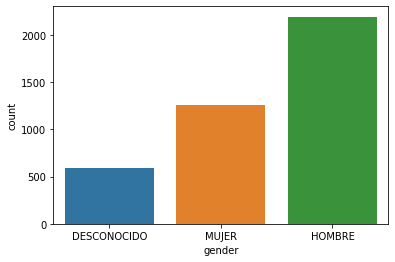

In [55]:
sns.barplot(data=datosGenero, x="gender", y="count")

In [69]:
topDistrict=[]
conexion = psycopg2.connect(host="localhost", database="Proyecto3", user="postgres", password="Oracle1Oracle1")

cur = conexion.cursor()
    
# Ejecutamos una consulta
cur.execute( "SELECT count(delito) as c, (sum(tasaocupacion)/count(delito)) as d, distrito FROM public.economia group by distrito order by c desc limit 10;")


# Recorremos los resultados y los mostramos
for c, d, delito in cur.fetchall() :
    infoUni=[]
    infoUni.append(c)
    infoUni.append(float(d))
    infoUni.append(delito)
    topDistrict.append(infoUni)


#print(topDistrict)    
topDelitosDistrito = pd.DataFrame(topDistrict, columns=['contDelito', 'conttasaOcupacion', 'delito'])
print(topDelitosDistrito)

# Cerramos la conexión
conexion.close() 

   contDelito  conttasaOcupacion                    delito
0         374          56.131611                san rafael
1         359          49.537078                   liberia
2         286          53.855069                  alajuela
3         262          49.321441  san isidro de el general
4         246          48.755414                 siquirres
5         243          57.027702                   heredia
6         200          54.706451              desamparados
7         160          58.129056                     uruca
8         153          57.358397                san isidro
9         143          46.059973                 turrialba


<AxesSubplot:xlabel='delito', ylabel='conttasaOcupacion'>

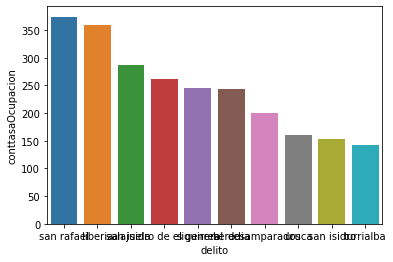

In [70]:
sns.barplot(data=topDelitosDistrito, x="delito", y="contDelito")
sns.barplot(data=topDelitosDistrito, x="delito", y="conttasaOcupacion")

In [62]:
byDistrict=[]
conexion = psycopg2.connect(host="localhost", database="Proyecto3", user="postgres", password="Oracle1Oracle1")

cur = conexion.cursor()
    
# Ejecutamos una consulta
cur.execute( "SELECT count(delito) as c, delito  FROM public.economia where distrito='desamparados' group by delito;")


# Recorremos los resultados y los mostramos
for c, delito in cur.fetchall() :
    infoUni=[]
    infoUni.append(c)
    infoUni.append(delito)
    byDistrict.append(infoUni)


delitosDistrito = pd.DataFrame(byDistrict, columns=['contDelito', 'delito'])
print(delitosDistrito)

# Cerramos la conexión
conexion.close() 

   contDelito             delito
0          14  TACHA DE VEHICULO
1          29   ROBO DE VEHICULO
2          61              HURTO
3          23               ROBO
4          69             ASALTO
5           4          HOMICIDIO


<AxesSubplot:xlabel='delito', ylabel='contDelito'>

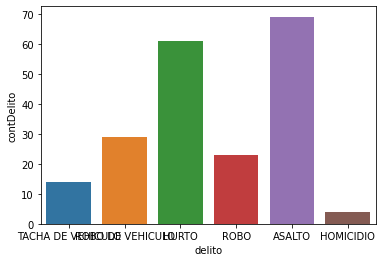

In [63]:
sns.barplot(data=delitosDistrito, x="delito", y="contDelito")

In [64]:
byNacion=[]
conexion = psycopg2.connect(host="localhost", database="Proyecto3", user="postgres", password="Oracle1Oracle1")

cur = conexion.cursor()
    
# Ejecutamos una consulta
cur.execute( "SELECT count(delito) as c, nacionalidad FROM public.economia group by nacionalidad;")


# Recorremos los resultados y los mostramos
for c, nacionalidad in cur.fetchall() :
    infoUni=[]
    infoUni.append(c)
    infoUni.append(nacionalidad)
    byNacion.append(infoUni)


delitosNacionalidad = pd.DataFrame(byNacion, columns=['contDelito', 'nacionalidad'])
print(delitosNacionalidad)

# Cerramos la conexión
conexion.close() 

    contDelito            nacionalidad
0            1                  SUECIA
1            3                   RUSIA
2            4                HONDURAS
3            4                  ITALIA
4            3               ARGENTINA
5            5             EL SALVADOR
6          157             Desconocido
7           25          ESTADOS UNIDOS
8           14                 FRANCIA
9            1    REPUBLICA DOMINICANA
10           1                   GHANA
11           2                  MEXICO
12           8                   CHINA
13           2                   SUIZA
14         283               NICARAGUA
15           5                  ESPANA
16           1                 POLONIA
17           2  PAISES BAJOS (HOLANDA)
18           1               GUATEMALA
19           1                  TAIWAN
20           7                ALEMANIA
21           4              INGLATERRA
22           1               AUSTRALIA
23          29               VENEZUELA
24           2           

<AxesSubplot:xlabel='nacionalidad', ylabel='contDelito'>

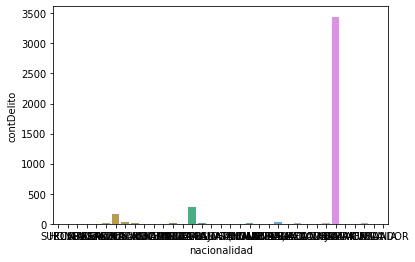

In [66]:
sns.barplot(data=delitosNacionalidad, x="nacionalidad", y="contDelito")

### Referencias

Ramírez de Garay, Luis David. (2014). Crimen y economía: una revisión crítica de las explicaciones económicas del crimen. Argumentos (México, D.F.), 27(74), 261-290. Recuperado de http://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S0187-57952014000100010&lng=es&tlng=es.

Suhong, K., Param, J., Parminder, K. y Pooya, T. (2018).Crime Analysis Through
Machine Learning. IEEE 9th Annual Information Technology, Electronics and Mobile Communication Conference (IEMCON) 
        
Instituto Nacional de Estadísticas y Censos (2011). Censo 2011: Indicadores
económicos, según provincia, cantón y distrito. Recuperado de
http://inec.cr/documento/censo-2011-indicadores-economicos-segun-provincia-canton-ydistrito

Organismo de Investigación Judicial (2018). Estadísticas poiciales. Recuperado de
https://sitiooij.poder-judicial.go.cr/index.php/apertura/transparencia/estadisticas-policiales

https://docs.microsoft.com/en-us/azure/synapse-analytics/spark/apache-spark-data-visualization-tutorial